In [ ]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import keras
import tensorflow as tf
from google.colab.patches import cv2_imshow



In [ ]:
#Resizing images, if needed
SIZE_X = 256 
SIZE_Y = 256
n_classes=3 #Number of classes for segmentation

#Capture training image info as a list
train_images = []

for directory_path in glob.glob('/content/drive/MyDrive/data/all_images'):
    for img_path in sorted (glob.glob(os.path.join(directory_path, "*.png"))):
        img = cv2.imread(img_path, 0)       #0 = gray scale 
        img = cv2.resize(img, (256, 256))
        train_images.append(img)


#Convert list to array for machine learning processing        
train_images = np.array(train_images)


train_masks = [] 
for directory_path in glob.glob('/content/drive/MyDrive/data/all_labels'):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        mask = cv2.imread(mask_path, 0)    
        mask = cv2.resize(mask, (256, 256), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)


In [ ]:
print (train_images.dtype)
print (train_masks.dtype)

uint8
uint8


In [ ]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)


# print (test_masks[0])

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.ravel()
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape= train_masks_reshaped_encoded.reshape(n, h, w)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(train_masks_reshaped.dtype)
print(train_masks_reshaped.shape)
print(np.unique(train_masks_encoded_original_shape))

uint8
(6225920,)
[0 1 2]


In [ ]:
train_masks_input= np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [ ]:
train_images = np.expand_dims(train_images, axis=3)
train_images= tf.keras.utils.normalize(train_images, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)


X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)


print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


Class values in the dataset are ...  [0 1 2]


In [ ]:
import tensorflow as tf
train_masks_cat = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

np.unique(y_train_cat)

import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
import tensorflow.keras.backend as K


In [ ]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred):
    """
    Function to calculate dice coefficient
    
    Parameters
    ----------
    y_true : numpy array of actual masks
    y_pred : numpy array of predicted masks
    
    Returns
    -------
    dice coefficient
    
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_coef_multilabel(y_true, y_pred):
    dice=0
    for index in range(3):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/3 # taking average


def dice_loss(y_true,y_pred):
  return 1- dice_coef_multilabel(y_true,y_pred)


In [ ]:

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import *
import keras

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH= X_train.shape[2]
IMG_CHANNELS= X_train.shape[3]

def unet(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    

    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)
    

    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([conv3,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv2,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv1,up8], axis = 3)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(n_classes, 1, activation = 'softmax')(conv8)

    model = tf.keras.Model(inputs = inputs, outputs = conv9)

    return model
        
    # if(pretrained_weights):
    #     model.load_weights(pretrained_weights)

    return model


unet()

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 train_masks_reshaped_encoded)

print("Class weights are...:", class_weights)


IMG_HEIGHT = train_images.shape[1]
IMG_WIDTH  = train_images.shape[2]
IMG_CHANNELS = train_images.shape[3]

from sklearn.utils import class_weight


model = unet(3,IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

from keras.callbacks import ModelCheckpoint, LearningRateScheduler
iou= tf.keras.metrics.MeanIoU(3)

filepath = "/content/drive/MyDrive/saved models/epoch-{epoch:02d}-loss-{loss:.5f}-val_loss-{val_loss:.8f}.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode= 'min')
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.00001), loss = [dice_loss], metrics = [dice_coef_multilabel])

model.summary()


# sample_weight = np.ones(shape=(len(train_masks_reshaped_encoded),))
# sample_cat= tf.keras.utils.to_categorical([0,1,2],3)
# sample_weight[train_masks_reshaped_encoded ==0] = 0.33727395
# sample_weight[train_masks_reshaped_encoded ==1] = 74.58692735
# sample_weight[train_masks_reshaped_encoded ==2] = 46.202116449233415




# history = model.fit(train_datagen.flow(X_train,y_train_cat, batch_size=50), 
#                     batch_size = 8, 
#                     verbose=1, 
#                     epochs=200, 
#                     callbacks = [model_checkpoint],
#                     validation_data=(validation_datagen.flow(X_test,y_test_cat,batch_size=1)), 
#                     #class_weight=class_weights,
#                     shuffle=False)
                    


history = model.fit(X_train,y_train_cat, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=200, 
                    callbacks = [model_checkpoint],
                    validation_data=(X_test,y_test_cat), 
                    #sample_weight=sample_weight,
                    shuffle=False)
                    


Class weights are...: [ 0.33727395 74.58692735 46.20211645]


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 256, 256, 32) 128         conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 32) 9248        batch_normalization_10[0][0]     
____________________________________________________________________________________________

dict_keys(['loss', 'dice_coef_multilabel', 'val_loss', 'val_dice_coef_multilabel'])


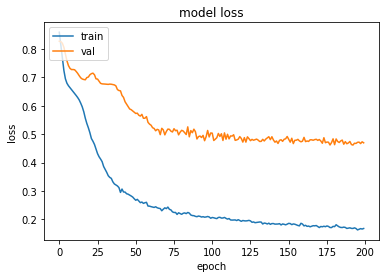

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model = unet()
model.load_weights('/content/drive/MyDrive/saved models/epoch-193-loss-0.16836-val_loss-0.46153650.hdf5')
y_pred= model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

#result = model.evaluate(X_test,y_test_cat)

from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2]  + values[1,0]+ values[2,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2]  + values[0,1]+ values[2,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)


Mean IoU = 0.46182188
[[6.37431e+05 3.18700e+03 7.32300e+03]
 [1.18000e+03 1.73800e+03 1.98000e+02]
 [2.45900e+03 1.93000e+02 1.65100e+03]]
IoU for class1 is:  0.9782851
IoU for class2 is:  0.26754925
IoU for class3 is:  0.13963126


In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='gray')
plt.show()